# Opening the Black Box of Deep Neural Networks

Deep neural networks have achieved near-human accuracy levels in various types of classification and prediction tasks. Despite numerous breakthroughs, Deep Neural Networks (DNNs) are often treated as "black boxes" owing to our poor understanding of their internal organization and optimization process. For various applications, the deep learning models did outperform other traditional methods by a large margin, but we can not understand how it can perform so well and wonder whether it is capable of capturing the underlying properties, i.e., learning something useful.  The interpretability of machine learning models is very important especially for the biomedical applications, in which the neural networks should provide human-understandable justifications for its output leading to insights about the inner workings. 

To have a better interpretation of the trained model, one key question that we would like to ask is which input features are the most important ones for classification? For a model trained for image classification, we would like to know which pixels or segments are important, for a model dealing with DNA sequences, we want to find out the important nucleotides, which may act as motif. 

To reveal the codes learnt by the models, several approaches for understanding and visualizing neural networks have been developed in the literature. In this snippet, we will briefly introduce some of these approaches and also applied these methods to a model which tries to learn sequence motif. For the sake of simplicity, we will only consider Convolutional Neural Networks (CNNs) in this snippet.


## Saliency Map

The intuition behind saliency map (and many other interpreting methods) is to find a way to assign weights (contribution to the final predicted outcome) to the input features, with which we can know the evidences identified by the model to make the predictions. The idea of saliency map is very straightforward, which is computing the gradient of output values respect to the input features. 

Given an input sequence $X_0$ of length $|X_0|$, a class label $c$, and a classification CNN model with the class score function $S_c(X)$, we want to rank the nucleotides of $X_0$ based on their influence on the score $S_c(X)$. We start with a simple example by considering the linear score model for the class $c$:

$$
S_c(X)=w_c^TX+b_c
$$

where input data $X$ is represented in the vectorised form, $w_c$ is the weight vector, and $b_c$ is the bias of the model. In this case, we can see that the magnitude of elements of $w$ defines the importance of the corresponding input element for the class $c$ . 

In the case of CNNs, the class score $S_c(X)$ is highly non-linear, so the simple method described above can not be directly applied.  How ever, around the point $X_0$, $S_c(X)$ can be approximated with a linear function by computing the first-order Taylor expansion:


$$
S_c(x) \approx w^TX+b
$$

where $w$ is the derivative of $S_c$ with respect to the sequence variable $X$ at the point $X_0$:

$$
w=\frac{\partial S_c}{\partial X}\bigg|_{X_0}
$$

The derivative $w$ is found by back-propagation, after which the saliency map can be obtained by rearranging the elements of the vector $w$. In the case of grey-scale image, the number of elments in $w$ is equal to the number of pixels in image, so the map can be computed as $M_{ij} =|w_{h(i,j)}|$, where $h(i,j)$ is the index of the elment of $w$, corresponding to the image pixel in the $i$-th row and $j$-th column. In the case of sequence, the map can also be computed as $M_i=|w_{h(i)}|$ for the $i$-th nucleotide in the input . 

Saliency map can tell us which nucleotides need to be changed the least in order to affect the class score the most. The computation of the saliency map for a single class is very fast, since it only requires a single back-propagation step.

## Guided Backpropagation

We can see that in the implementation of saliency map, we do not care the direction of the influence and only care about the absolute value of gradient. This may not work well in some cases, as shown in the example (left panel) below, and guided backpropagation can produce a good interpretation of the feature imporantence in this case (right panel). We know that the neurons (filters) in the CNN models act like detectors of particular patterns. Actually, we are only interested in what feature patterns the neuron detects, not in what kind of stuff it doesn’t detect, and this is the intuition behind guided backpropagation.  

<img src="img/Compare.jpg" width="80%">

Compared to the standart backpropagation, the only modification of guided backpropagation is to set all the negative gradients to zero when propagating the gradient, which means we do not care if a nucleotide (or pixel) "suppresses" a neuron somewhere along the path to our neuron.

Here is an example comparing different methods of propagating back through a ReLU nonlinearity. The figure (c) below shown formal definition of different methods for propagating a output activation out back through a ReLU unit in layer l. The deconvnet here is like the reverse process of convolution nerual network. Note that the deconvnet approach and guided backpropagation do not compute a true gradient but rather an imputed version.

<img src="img/Guided.jpg" width="90%">

## Limitations of gradient-based methods

### Saturation problem

Consider the simple network shown below, there is one hidden neuron $h$ which computes $max(0, 1-i_1-i_2)$, and there’s the output neuron $y$ which is $1-h$. The functions computed by $h$ and $y$ are shown on the left. Let’s look at the point where $i_1 = 1$ and $i_2 = 1$. Here, the output of the network is 1. If, at this point, we individually zero out an input, we will not observe a change in the output. Since in this region the gradient to the input already becomes zero. This may mislead the user into thinking neither input is relevant to the prediction. 

<img src="img/Saturation.jpg" width="50%">

### Discontinuous gradients

Another potential issue of gradient-based methods is about discontinuities in the gradients. The figure below provides an example of why discontinuous gradients may produce misleading importance scores. Here the neuron $y$ is the response of a single rectified linear unit with a bias of -10. Both gradient and gradient\*input have a discontinuity at $x = 10$; at $x = 10 + \epsilon$, gradient\*input assigns a contribution of $10 + \epsilon$ to $x$ and -10 to the bias term ($\epsilon$ is a small positive number). When $x < 10$, contributions on $x$ and the bias term are both 0. By contrast, the difference-from-reference (red arrow) gives a continuous increase in the contribution score.

<img src="img/Discontinue.jpg" width="50%">

## Integrated Gradients

Integrated gradients is another method to tackle the problem of attributing the prediction of a deep network to its input features. Unlike the two methods above, it needs a baseline or reference input to better calculate the contribution of each feature. 

Formally, suppose we have a function $F:R^n\rightarrow[0,1]$ representing a neural network model, let $x\in R^n$ be the input, and $x'\in R^n$ be the baseline input. For image networks, the baseline could be the black image, while for sequence data, the base line can be defined base on the average GC content of the genome. 

We consider the **straightline path** (in $R^n$) from the baseline $x′$ to the input $x$, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients. Specifically, integrated gradients are defined as the path intergral of the gradients along the straightline path from the baseline $x′$ to the input $x$, as the path P2 shown in the figure below. 

<img src="img/Path.jpg" width="30%">

The integrated gradient along the $i$-th dimension for an input $x$ and baseline $x'$ is defined as follows:

IntegratedGrad$s_i(x)::=(x_i-x'_i)\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha\times(x-x'))}{\partial x_i}d\alpha$ ,

where $\frac{\partial F(x)}{\partial x_i}$ is the gradient of $F(x)$ along the $i$-th dimension.

We can simply sum the gradients at points occurring at sufficiently small intervals along the straightline path from the baseline $x′$ to the input $x$ to approximate the integral efficiently, as shown in the formula below: 
$$
IntegratedGrads_i^{approx}(x)::=(x_i-x_i')\times \sum_{k=1}^m \frac{\partial F(x'+\frac{k}{m}\times (x-x'))}{\partial x_i} \times \frac{1}{m}
$$
where $m$ is the number of steps in the approximation of the integral. 

This approximation simply involves computing the gradient in a for loop which should be easy and efficient in most deep learning frameworks. In practice, the authors find that somewhere between 20 and 300 steps are enough to approximate the integral (within 5%).

## DeepLIFT

Although integrated gradient can avoid the limitations of the gradient-based methods, numerically obtaining high-quality integrals adds computational overhead. DeepLIFT is another method which also tries to explain the difference in output from some "reference" output in terms of the difference of the input from some "reference" input while keeping efficient. 

Formally, let $t$ represent target output neuron of interest, suppose $x_i(i=1..n)$ represent some neurons in some intermediate layer or set of layers that are *necessary and sufficient* to compute $t$. We define the quantity $\Delta t$ to be the difference-from-reference with respect to the reference activation $t^0$ , i.e., $\Delta t=t-t^0$. Then DeepLIFT assigns contribution scores $C_{\Delta{x_i}{\Delta t}}$ to $\Delta{x_i}$ such that 

$$
\sum_{i=1}^n C_{\Delta{x_i}{\Delta t}}=\Delta t
$$


which is called the **summation-to-delta** property. Here the contribution score $C_{\Delta{x_i}{\Delta t}}$ can be thought of as the amount of difference-from-reference in $t$ that is attributed to the difference-from-reference of $x_i$.

### Multipliers and the Chain Rule
Then DeepLIFT tries to define something similar to a partial derivative, called multiplier. For a given input $x$ and target neuron $t$ that we want to compute the contribution to, the multiplier $m_{\Delta x{\Delta t}}$ is defined as:

$$
m_{\Delta{x}{\Delta t}}=\frac{C_{\Delta{x}{\Delta t}}}{\Delta x}
$$

which is the contribution of $\Delta x$ to $\Delta t$ divided by $\Delta x$. 


It turns out that this multiplier also has chain rule. Suppose we have an input layer with neurons $x_1,\dots,x_n$, a hidden layer with neurons $y_1, \dots, y_n$, and some target output neuron $z$. Given values for $m_{\Delta x_i \Delta y_j}$ and $m_{\Delta y_j \Delta z}$, the following definition of $m_{\Delta x_i \Delta z}$ is consistent with the summation-to-delta property:

$$
m_{\Delta x_i \Delta z}=\sum_j m_{\Delta x_i \Delta y_j} m_{\Delta y_j \Delta z}
$$

With this chain rule, we can compute the multipliers for any neuron to a given target neuron efficiently via backpropagation. 

In some situations, we may want to separate positive and negative contributions. To do this, DeepLIFT introduces $\Delta x_i^+$ and $\Delta x_i^-$ that represent the positive and negative components of $\Delta x_i$, such that:

$$
\Delta x_i = \Delta x_i^+ + \Delta x_i^-
$$
$$
C_{\Delta{x_i}{\Delta t}} = C_{\Delta{x_i^+}{\Delta t}} + C_{\Delta{x_i^-}{\Delta t}}
$$

Then DeepLIFT defines a set of rules for assigning contribution scores. 

### The linear rule
The simplest rule is the linear rule, which applies to Dense and Convolution layers. Assume $y$ is a linear function of its input $x_i$, then the linear rule is defined as below:

<img src="img/Linear.jpg" width="70%">

### The rescale rule
Then how to deal with the non-linear model? DeepLIFT provides two rules for nonlinearities, which are the rescale rule and the revealcancel rule. Here we will only discuss the rescale rule.

The rescale rule sets $\Delta y^+$ and$\Delta y^-$ proportional to $\Delta x^+$ and $\Delta x^-$. We assume that all the contribution to $\Delta y^+$ comes from $\Delta x^+$ and similarly for $\Delta y^-$, which leads to the multipliers simply being the ratio of the change in the output divided by the change in the input.

Formally, suppose $y=f(x)$ is a nonlinear transformation of its input $x$. Because $y$ only has one input, we can have $C_{\Delta{x}{\Delta y}}=\Delta y$, and thus $m_{\Delta x \Delta y}=\frac{\Delta y}{\Delta x}$, then we set:
$$
\Delta y^+ = \frac{\Delta y}{\Delta x}\Delta x^+ = C_{\Delta x^+ \Delta y^+}
$$

$$
\Delta y^- = \frac{\Delta y}{\Delta x}\Delta x^- = C_{\Delta x^- \Delta y^-}
$$
Based on this, we get:
$$
m_{\Delta x^+ \Delta y^+} = m_{\Delta x^- \Delta y^-} = m_{\Delta x \Delta y} = \frac{\Delta y}{\Delta x}
$$

For the revealcancel rule, please refer to the original DeepLIFT paper for details. 

## Genomics example provided by DeepLIFT

Adapted from https://github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb.

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:

- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

### Obtain data and keras model
We will download genomic data and model

#### Download the data and model

In [2]:
!./grab_model_and_data.sh

File sequences.simdata.gz exists already
File keras2_conv1d_record_5_model_PQzyq_modelJson.json exists already
File keras2_record_5_model_PQzyq_modelWeights.h5 exists already
File test.txt.gz exists already


The simdna, deeplift, and keras packages are needed for reading the data; install them if it doesn't exist

In [ ]:
!pip install keras
!pip install deeplift
!pip install -e "git://github.com/kundajelab/simdna.git@0.4.0#egg=simdna"

#### Read in and one-hot encode the data

Read in data

In [2]:
import simdna.synthetic as synthetic
from importlib import reload
reload(synthetic)
reload(synthetic.core)
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode('utf8').rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

One-hot encode the data

In [3]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

#### Load the keras model

In [24]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import deeplift
from keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_1 (Activation)    (None, 190, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_2 (Activation)    (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)               

### Prepare the deeplift models

#### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT, gradients and guided backprop

In [25]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: Rescale
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
nonlinear_mxts_mode is set to: Gradient
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func


### Compute importance scores

#### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [18]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


#### Call scoring functions on the data

In the cell below, a reference representing 40% GC content is used

In [19]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[onehot_data],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). 
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


### Visualize scores on individual sequences

Visualize the scores at specific sequences. Green boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, blue boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 1 for example 197
grad_times_inp


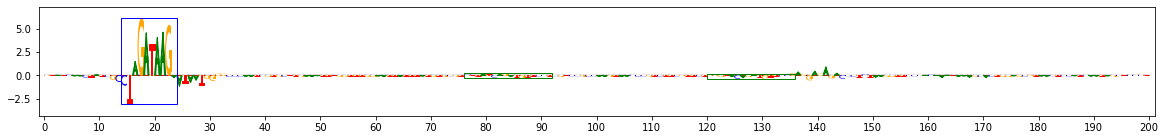

guided_backprop


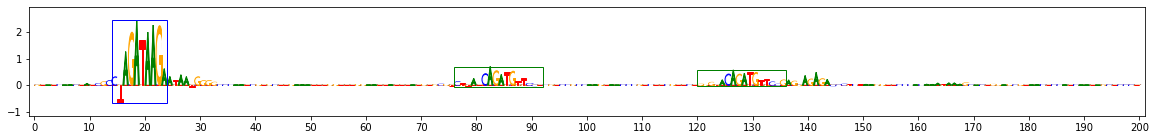

integrated_gradients10


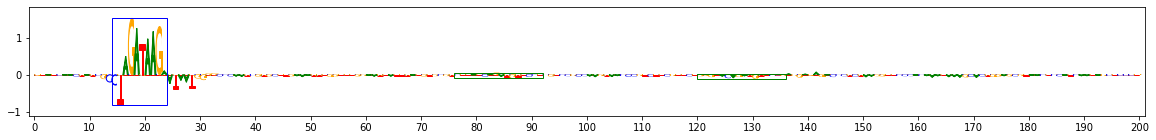

rescale_all_layers


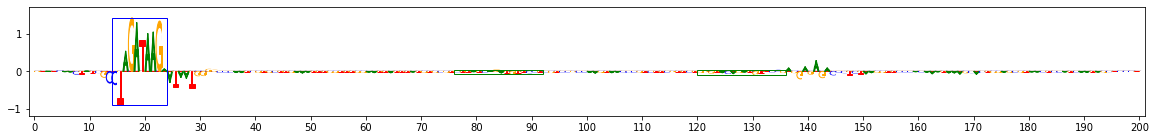

In [22]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(1,197)]:  # for task 1 ("contains GATA1"), illustrates non-specific firing of guided backprop              
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'grad_times_inp',
                        'guided_backprop',
                        'integrated_gradients10',
                        'rescale_all_layers'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_onehot = onehot_data[idx]
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
        highlight = {'blue':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
                'green':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

## References and related materials

1. Saliency map paper: 
[Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)

2. Guided backpropagation paper:
[Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)

3. Integrated gradient paper:
[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)

4. DeepLIFT paper:
[Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1704.02685)

5. DeepLIFT github:
https://github.com/kundajelab/deeplift/

6. DeepLIFT talk given at ICML:
https://vimeo.com/238275076
